# Scaling Up To Casino Blackjack

### Imports & Config

In [1]:
# Notebook 2 — Scaling Up to Casino Blackjack

import random
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Actions
HIT, STAND, DOUBLE = 0, 1, 2
ACTION_NAMES = {HIT: "H", STAND: "S", DOUBLE: "D"}

# Environment config (can tweak)
N_DECKS = 6
RESHUFFLE_THRESHOLD = 52          # reshuffle when shoe drops below this many cards
DEALER_STANDS_SOFT_17 = True      # S17 rule
BLACKJACK_PAYOUT = 1.5            # natural 21 pays 3:2

### 6-Deck Casino Blackjack Environment

In [2]:
class CasinoBlackjackEnv:
    """
    6-deck blackjack with:
      - Dealer stands on soft 17 (S17) if DEALER_STANDS_SOFT_17=True
      - Blackjack pays 3:2
      - Actions: HIT (0), STAND (1), DOUBLE (2)
      - Double allowed only on the first decision (exactly two player cards)
      - No splits, no surrender
    Observations (state):
      (player_total, dealer_upcard, usable_ace, allow_double)
    Reward:
      +1 win, -1 loss, 0 push (multiplied by 2 if doubled)
      +1.5 on player blackjack vs non-blackjack dealer
    """

    def __init__(self,
                 n_decks=N_DECKS,
                 reshuffle_threshold=RESHUFFLE_THRESHOLD,
                 dealer_stands_soft17=DEALER_STANDS_SOFT_17,
                 blackjack_payout=BLACKJACK_PAYOUT):
        self.n_decks = n_decks
        self.reshuffle_threshold = reshuffle_threshold
        self.dealer_stands_soft17 = dealer_stands_soft17
        self.blackjack_payout = blackjack_payout

        self.shoe = []
        self.player = []
        self.dealer = []
        self.allow_double = True
        self._init_shoe()

    # ---------- Shoe & dealing ----------
    def _init_shoe(self):
        self.shoe = []
        # Cards: 1 (Ace), 2-9, 10 (T/J/Q/K)
        one_deck = [1,2,3,4,5,6,7,8,9,10,10,10,10] * 4
        self.shoe = one_deck * self.n_decks
        random.shuffle(self.shoe)

    def _draw(self):
        if len(self.shoe) < self.reshuffle_threshold:
            self._init_shoe()
        return self.shoe.pop()

    # ---------- Hand utilities ----------
    @staticmethod
    def _hand_value(cards):
        total = sum(cards)
        usable_ace = 1 in cards and total + 10 <= 21
        return (total + 10, True) if usable_ace else (total, False)

    @staticmethod
    def _is_blackjack(cards):
        return len(cards) == 2 and set(cards) & {1} and (sum(cards) == 11 or sum(cards) == 21)

    def _obs(self):
        total, usable = self._hand_value(self.player)
        upcard = self.dealer[0]
        return (total, upcard, usable, self.allow_double)

    # ---------- Dealer policy ----------
    def _dealer_play(self):
        while True:
            total, usable = self._hand_value(self.dealer)
            if total < 17:
                self.dealer.append(self._draw())
                continue
            if total == 17 and usable and not self.dealer_stands_soft17:
                # H17 (not used in this notebook, but kept for completeness)
                self.dealer.append(self._draw())
                continue
            break

    # ---------- Round resolution ----------
    def _compare(self, player_total, dealer_total):
        if player_total > 21:
            return -1
        if dealer_total > 21:
            return +1
        if player_total > dealer_total:
            return +1
        if player_total < dealer_total:
            return -1
        return 0  # push

    # ---------- Gym-like API ----------
    def reset(self):
        if len(self.shoe) < self.reshuffle_threshold:
            self._init_shoe()

        self.player = [self._draw(), self._draw()]
        self.dealer = [self._draw(), self._draw()]
        self.allow_double = True

        # Natural checks
        player_blackjack = self._is_blackjack(self.player)
        dealer_blackjack = self._is_blackjack(self.dealer)

        if player_blackjack or dealer_blackjack:
            # Episode ends immediately
            if player_blackjack and dealer_blackjack:
                reward = 0.0
            elif player_blackjack:
                reward = self.blackjack_payout
            else:
                reward = -1.0
            obs = self._obs()
            return obs, reward, True, {}

        return self._obs(), 0.0, False, {}

    def step(self, action):
        """
        Returns: next_obs, reward, done, info
        """
        # Enforce double allowed only once (on the first decision)
        if action == DOUBLE and not self.allow_double:
            action = HIT  # fallback

        if action == HIT:
            self.player.append(self._draw())
            self.allow_double = False
            player_total, _ = self._hand_value(self.player)
            if player_total > 21:  # player busts
                return self._obs(), -1.0, True, {}
            return self._obs(), 0.0, False, {}

        elif action == STAND:
            self.allow_double = False
            self._dealer_play()
            p_total, _ = self._hand_value(self.player)
            d_total, _ = self._hand_value(self.dealer)
            reward = self._compare(p_total, d_total)
            return self._obs(), float(reward), True, {}

        else:  # DOUBLE
            # Take exactly one card, then stand; reward is doubled
            self.player.append(self._draw())
            self.allow_double = False
            p_total, _ = self._hand_value(self.player)
            if p_total > 21:  # bust on double
                return self._obs(), -2.0, True, {"doubled": True}

            self._dealer_play()
            p_total, _ = self._hand_value(self.player)
            d_total, _ = self._hand_value(self.dealer)
            base = self._compare(p_total, d_total)
            return self._obs(), float(2 * base), True, {"doubled": True}

### ε-Greedy, Q-Learning, and Helpers

In [3]:
def epsilon_greedy(Q, state, epsilon, valid_actions):
    """Choose action from Q with epsilon-greedy over the valid actions."""
    if np.random.rand() < epsilon:
        return np.random.choice(valid_actions)
    # Greedy among valid actions only
    q_vals = [Q[state][a] for a in valid_actions]
    return valid_actions[int(np.argmax(q_vals))]

def valid_actions_from_state(state):
    """Mask DOUBLE if not allowed; otherwise all actions are valid."""
    _, _, _, allow_double = state
    return [HIT, STAND, DOUBLE] if allow_double else [HIT, STAND]

def q_learning(env,
               num_episodes=500_000,
               alpha=0.05,
               gamma=1.0,
               epsilon_start=0.2,
               epsilon_end=0.02):
    """
    Tabular Q-learning for our blackjack env.
    Returns: Q dict and greedy policy dict
    """
    Q = defaultdict(lambda: np.zeros(3))
    epsilon = epsilon_start

    for ep in range(1, num_episodes + 1):
        state, _, done, _ = env.reset()
        if done:
            # Natural resolution on reset; single update isn't meaningful here, skip to next episode
            continue

        # Linear decay
        epsilon = max(epsilon_end, epsilon_start * (1 - ep / num_episodes))

        while True:
            actions = valid_actions_from_state(state)
            a = epsilon_greedy(Q, state, epsilon, actions)

            next_state, r, done, info = env.step(a)

            # Next state's valid actions (for greedy bootstrap)
            if done:
                target = r
            else:
                next_actions = valid_actions_from_state(next_state)
                target = r + gamma * np.max([Q[next_state][na] for na in next_actions])

            # Q-update
            Q[state][a] += alpha * (target - Q[state][a])

            state = next_state
            if done:
                break

    # Greedy policy extraction (respecting action masks)
    policy = {}
    for s, qvals in Q.items():
        valid = valid_actions_from_state(s)
        best = valid[int(np.argmax([qvals[a] for a in valid]))]
        policy[s] = best
    return Q, policy

### Train the Agent

In [4]:
env = CasinoBlackjackEnv()

# You can tweak episodes/alpha/epsilon for speed vs quality
Q, policy = q_learning(
    env,
    num_episodes=400_000,
    alpha=0.05,
    gamma=1.0,
    epsilon_start=0.2,
    epsilon_end=0.02
)

len(Q), "unique states learned"

(510, 'unique states learned')

### Policy Visualization (Heatmaps + Tables)

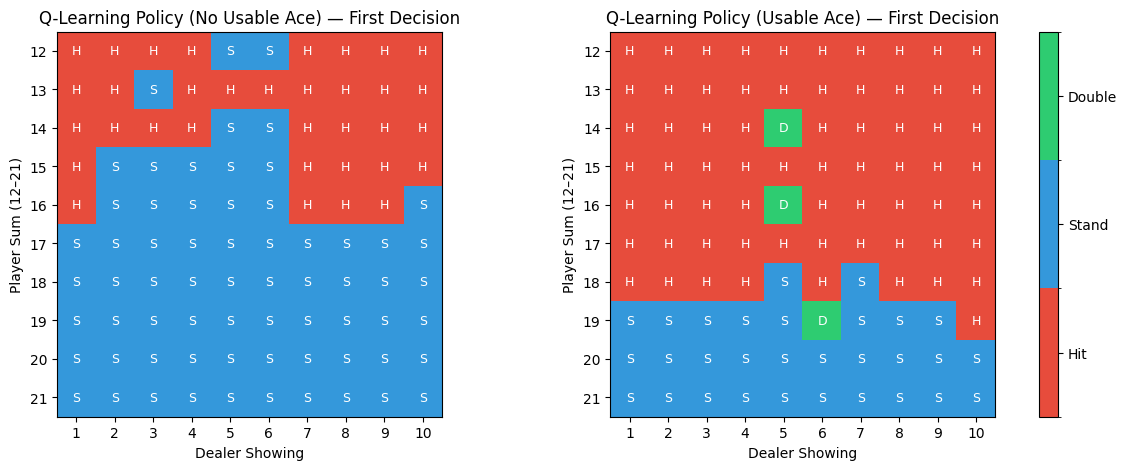

=== Learned Policy (First Decision) — No Usable Ace ===
       1 2 3 4 5 6 7 8 9 10
Hard 12: H H H H S S H H H H
Hard 13: H H S H H H H H H H
Hard 14: H H H H S S H H H H
Hard 15: H S S S S S H H H H
Hard 16: H S S S S S H H H S
Hard 17: S S S S S S S S S S
Hard 18: S S S S S S S S S S
Hard 19: S S S S S S S S S S
Hard 20: S S S S S S S S S S
Hard 21: S S S S S S S S S S

=== Learned Policy (First Decision) — Usable Ace ===
       1 2 3 4 5 6 7 8 9 10
Soft 12: H H H H H H H H H H
Soft 13: H H H H H H H H H H
Soft 14: H H H H D H H H H H
Soft 15: H H H H H H H H H H
Soft 16: H H H H D H H H H H
Soft 17: H H H H H H H H H H
Soft 18: H H H H S H S H H H
Soft 19: S S S S S D S S S H
Soft 20: S S S S S S S S S S
Soft 21: S S S S S S S S S S


In [5]:
def extract_policy_grid(policy, usable_ace=False, allow_double=True):
    """
    Build a 10x10 grid for player totals 12–21 vs dealer upcards 1–10.
    Each cell stores the greedy action (H/S/D) in that state if present,
    otherwise defaults to Stand.
    """
    grid = np.full((10, 10), STAND, dtype=int)
    for player in range(12, 22):
        for dealer in range(1, 11):
            s = (player, dealer, usable_ace, allow_double)
            if s in policy:
                grid[player - 12, dealer - 1] = policy[s]
    return grid

def plot_policy_heatmaps(grid_hard, grid_soft, title_prefix="Learned"):
    """
    3-color heatmap: H=0, S=1, D=2
    """
    cmap = ListedColormap(["#e74c3c", "#3498db", "#2ecc71"])  # red=H, blue=S, green=D
    bounds = [-0.5, 0.5, 1.5, 2.5]
    norm = plt.matplotlib.colors.BoundaryNorm(bounds, cmap.N)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    for ax, grid, label in zip(axes, [grid_hard, grid_soft], ["No Usable Ace", "Usable Ace"]):
        im = ax.imshow(grid, cmap=cmap, norm=norm, origin="upper")
        ax.set_title(f"{title_prefix} Policy ({label}) — First Decision")
        ax.set_xlabel("Dealer Showing")
        ax.set_ylabel("Player Sum (12–21)")
        ax.set_xticks(np.arange(10))
        ax.set_xticklabels(np.arange(1, 11))
        ax.set_yticks(np.arange(10))
        ax.set_yticklabels(np.arange(12, 22))

        # Annotate with H/S/D letters for readability
        for i in range(grid.shape[0]):
            for j in range(grid.shape[1]):
                ax.text(j, i, ACTION_NAMES[grid[i, j]], ha="center", va="center", fontsize=9, color="white")

    cbar = fig.colorbar(im, ax=axes, ticks=[0, 1, 2], fraction=0.025, pad=0.04)
    cbar.ax.set_yticklabels(["Hit", "Stand", "Double"])
    plt.show()

def summarize_policy_table(policy, usable_ace=False, allow_double=True):
    header = "       " + " ".join([str(d) for d in range(1, 11)])
    lines = [header]
    for total in range(12, 22):
        row = []
        for dealer in range(1, 11):
            s = (total, dealer, usable_ace, allow_double)
            a = policy.get(s, STAND)
            row.append(ACTION_NAMES[a])
        lines.append(f"{'Soft' if usable_ace else 'Hard'} {total}: " + " ".join(row))
    return "\n".join(lines)

# Build “first decision” grids (allow_double=True)
grid_hard = extract_policy_grid(policy, usable_ace=False, allow_double=True)
grid_soft = extract_policy_grid(policy, usable_ace=True,  allow_double=True)

# Plot & print
plot_policy_heatmaps(grid_hard, grid_soft, title_prefix="Q-Learning")
print("=== Learned Policy (First Decision) — No Usable Ace ===")
print(summarize_policy_table(policy, usable_ace=False, allow_double=True))
print("\n=== Learned Policy (First Decision) — Usable Ace ===")
print(summarize_policy_table(policy, usable_ace=True, allow_double=True))

### Evaluate EV (Expected Value per Hand)

In [6]:
def greedy_action(Q, state):
    """Pick the best valid action from Q for a given state."""
    valid = valid_actions_from_state(state)
    qvals = [Q[state][a] for a in valid]
    return valid[int(np.argmax(qvals))]

def play_hand_with_policy(env, Q):
    """
    Play a single hand using the greedy policy from Q.
    Returns the net reward for a 1-unit base bet.
    """
    state, reward, done, _ = env.reset()
    if done:
        # Natural resolution (BJ/push/dealer BJ) is already fully paid out here.
        return reward

    while True:
        a = greedy_action(Q, state)
        next_state, r, done, _ = env.step(a)
        reward += r
        state = next_state
        if done:
            return reward

def evaluate_ev(env, Q, n_episodes=100_000):
    rewards = []
    for _ in range(n_episodes):
        rewards.append(play_hand_with_policy(env, Q))
    rewards = np.array(rewards)
    ev = rewards.mean()
    return ev, rewards

ev, rewards = evaluate_ev(env, Q, n_episodes=50_000)
print(f"Estimated EV per initial bet: {ev:.4f}  ({ev*100:.2f}%)")
print(f"Win rate: {(rewards>0).mean():.3f},  Push rate: {(rewards==0).mean():.3f},  Loss rate: {(rewards<0).mean():.3f}")

Estimated EV per initial bet: -0.0436  (-4.36%)
Win rate: 0.424,  Push rate: 0.087,  Loss rate: 0.489


### Compare “First Decision Only” vs “Anytime”

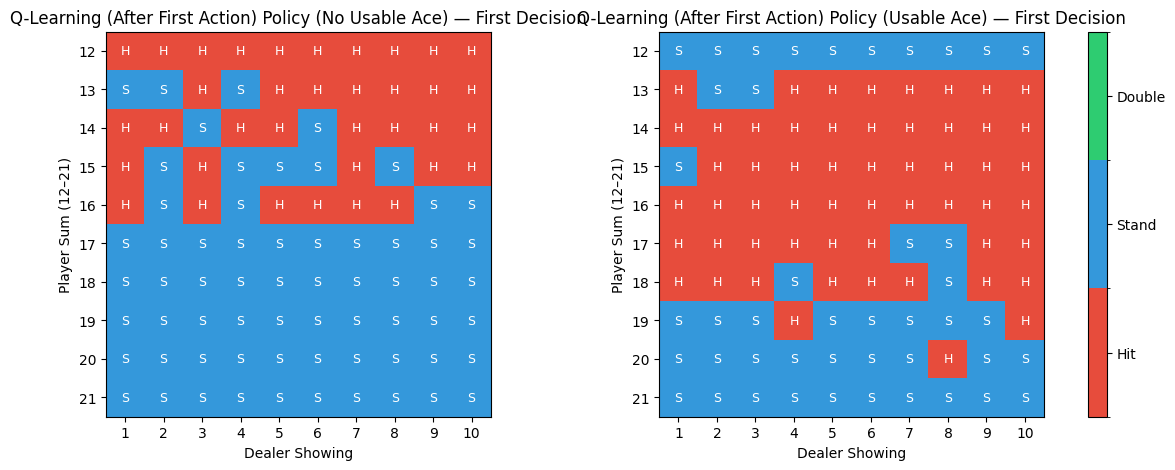

=== Policy (After First Action) — No Usable Ace ===
       1 2 3 4 5 6 7 8 9 10
Hard 12: H H H H H H H H H H
Hard 13: S S H S H H H H H H
Hard 14: H H S H H S H H H H
Hard 15: H S H S S S H S H H
Hard 16: H S H S H H H H S S
Hard 17: S S S S S S S S S S
Hard 18: S S S S S S S S S S
Hard 19: S S S S S S S S S S
Hard 20: S S S S S S S S S S
Hard 21: S S S S S S S S S S

=== Policy (After First Action) — Usable Ace ===
       1 2 3 4 5 6 7 8 9 10
Soft 12: S S S S S S S S S S
Soft 13: H S S H H H H H H H
Soft 14: H H H H H H H H H H
Soft 15: S H H H H H H H H H
Soft 16: H H H H H H H H H H
Soft 17: H H H H H H S S H H
Soft 18: H H H S H H H S H H
Soft 19: S S S H S S S S S H
Soft 20: S S S S S S S H S S
Soft 21: S S S S S S S S S S


In [7]:
grid_hard_late = extract_policy_grid(policy, usable_ace=False, allow_double=False)
grid_soft_late = extract_policy_grid(policy, usable_ace=True,  allow_double=False)

plot_policy_heatmaps(grid_hard_late, grid_soft_late, title_prefix="Q-Learning (After First Action)")
print("=== Policy (After First Action) — No Usable Ace ===")
print(summarize_policy_table(policy, usable_ace=False, allow_double=False))
print("\n=== Policy (After First Action) — Usable Ace ===")
print(summarize_policy_table(policy, usable_ace=True, allow_double=False))